In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import sqlite3

In [2]:
con = sqlite3.connect('../nonelite.db')

sql = """
SELECT * FROM nonelite
UNION
SELECT * FROM elite;
"""
df = pd.read_sql_query(sql, con)
con.close()

# RUN ONLY ONCE

# 2015-2017 only has a 70+ category, while 2018-2019 have 70-74, etc. so we need to combine those into 70+
df.loc[df['category'].isin(['70-74', '75-79', '80-84']), 'category'] = '70+'


# all dates are read as strings
# convert diff in MM:SS to datetime HH:MM:SS. any missing values are coerced to NaT
df.loc[:, df.columns.str.contains('diff')] = df.loc[:, df.columns.str.contains('diff')].apply(lambda x:
pd.to_datetime(x, format='%M:%S', errors='coerce').dt.time)

# convert all other splits in HH:MM:SS to datetime HH:MM:SS
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].apply(lambda x:
pd.to_datetime(x, format='%H:%M:%S', errors='coerce').dt.time)

# convert everything back to a string...
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].astype(str)

# finally, convert strings to timedelta, then obtain all times in total seconds
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].apply(lambda x:
pd.to_timedelta(x, errors='coerce').dt.total_seconds())

df['split_Half2'] = df['split_Finish'] - df['split_Half']
df['split_25K_diff'] = df['split_Half_diff'] + df['split_25K_diff']
# it is MUCH easier to work with everything in terms of seconds, and then convert back
# to a human readable format after all operations are completed


# for each year and gender, assign a quartile (1,2,3,4) to each runner 
df = df.sort_values(by=['split_Finish'])
df['quartile'] = 1
for yr in [2015, 2016, 2017, 2018, 2019]:
    for g in ['M', 'F']:
        temp = df[(df['year']==yr) & (df['gender']==g)]['split_Finish']
        rank = [temp.quantile(.25), temp.quantile(.5), temp.quantile(.75)]
        df.loc[(df['year']==yr) & (df['gender']==g), 'quartile'] = [1 if time < rank[0] else 2 if time < rank[1] else 3 if time < rank[2] else 4 for time in temp]
    
    
df.loc[:, df.columns.str.contains('split')].head()

,split_5K,split_5K_diff,split_10K,split_10K_diff,split_15K,split_15K_diff,split_20K,split_20K_diff,split_Half,split_Half_diff,...,split_25K_diff,split_30K,split_30K_diff,split_35K,split_35K_diff,split_40K,split_40K_diff,split_Finish,split_Finish_diff,split_Half2
93870,863.0,863.0,1741.0,879.0,2622.0,882.0,3505.0,883.0,3697.0,192.0,...,854.0,5224.0,867.0,6115.0,892.0,6980.0,866.0,7357.0,378.0,3660.0
62117,863.0,863.0,1742.0,879.0,2622.0,881.0,3505.0,883.0,3697.0,192.0,...,854.0,5224.0,866.0,6115.0,892.0,6982.0,867.0,7375.0,393.0,3678.0
97705,856.0,856.0,1717.0,861.0,2597.0,881.0,3490.0,894.0,3684.0,194.0,...,870.0,5233.0,875.0,6127.0,894.0,7009.0,883.0,7385.0,377.0,3701.0
181280,863.0,863.0,1742.0,879.0,2623.0,881.0,3505.0,883.0,3697.0,192.0,...,857.0,5224.0,863.0,6116.0,892.0,6989.0,873.0,7396.0,408.0,3699.0
15572,856.0,856.0,1717.0,861.0,2597.0,881.0,3491.0,894.0,3684.0,194.0,...,870.0,5233.0,874.0,6127.0,894.0,7018.0,892.0,7431.0,413.0,3747.0


In [3]:
df.columns

Index(['name', 'country', 'club', 'category', 'id', 'place_gender',
       'place_category', 'place_overall', 'gender', 'elite', 'split_5K',
       'split_5K_diff', 'split_10K', 'split_10K_diff', 'split_15K',
       'split_15K_diff', 'split_20K', 'split_20K_diff', 'split_Half',
       'split_Half_diff', 'split_25K', 'split_25K_diff', 'split_30K',
       'split_30K_diff', 'split_35K', 'split_35K_diff', 'split_40K',
       'split_40K_diff', 'split_Finish', 'split_Finish_diff', 'year',
       'split_Half2', 'quartile'],
      dtype='object')

In [4]:
# look at average times by category

def df_selector(df, level, keywords):
    """Utility fxn to select the level and columns to search for a multiindex df.
    keywords must be a list of column names. If the list is length >1, it will perform exact matching.
    """
    if len(keywords) > 1:
        return df.loc[:, df.columns.get_level_values(level).isin(keywords)]
    return df.loc[:, df.columns.get_level_values(level).str.contains(keywords[0])]


def split_format(df, names = None, multi=False):
    """Convert all time columns in df from seconds to timedelta (HH:MM:SS)
    multi denotes MultiIndex columns, which will select split -> mean 
    otherwise, names will expect a list of column names containing split data
    """
    if multi:
        temp = df_selector(df, 0, ['split'])
        temp = df_selector(temp, 1, ['mean'])
        return temp.apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))
    else:
        return df.loc[:, names].apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))


def CoV(x):
    """Coefficient of Variation = sd/mean*100 """
    return np.round(np.std(x)/np.mean(x)*100,1)



m = df.groupby(['year', 'elite', 'gender']).agg([np.mean, CoV])
m = df_selector(m, 0, ['split'])
m


split_5K       split_5K_diff          split_10K  \
                             mean   CoV          mean   CoV         mean   
year elite    gender                                                       
2015 elite    F       1031.777778   2.0   1031.777778   2.0  2050.333333   
              M        911.952381   3.9    911.952381   3.9  1830.142857   
     nonelite F       1845.622536  15.4   1845.491921  15.4  3722.475244   
              M       1628.140540  16.6   1628.140540  16.6  3273.045156   
2016 elite    F       1019.842105   2.4   1019.842105   2.4  2046.421053   
              M        906.629630   4.2    906.629630   4.2  1818.111111   
     nonelite F       1866.976424  15.7   1866.976424  15.7  3766.669846   
              M       1640.362624  17.3   1640.362624  17.3  3291.156331   
2017 elite    F       1012.807692   5.1   1012.807692   5.1  2040.923077   
              M        900.645161   4.0    900.645161   4.0  1827.225806   
     nonelite F       1866.484554  16.0   1866.484554  16.0  3779.580969   
              M       1631.480138  17.9   1631.480138  17.9  3292.152197   
2018 elite    F       1004.615385   4.3   1004.615385   4.3  2028.538462   
              M        876.388889   5.8    876.388889   5.8  1782.555556   
     nonelite F       1900.042558  17.4   1899.424799  17.3  3892.091979   
              M       1649.141709  18.5   1649.141709  18.5  3354.741777   
2019 elite    F       1023.857143   1.0   1023.857143   1.0  2048.047619   
              M        906.666667   3.8    906.666667   3.8  1829.277778   
     nonelite F       1850.678934  17.0   1850.678934  17.0  3754.392322   
              M       1620.590859  18.0   1620.220940  18.0  3275.156961   

                           split_10K_diff          split_15K        ...  \
                       CoV           mean   CoV         mean   CoV  ...   
year elite    gender                                                ...   
2015 elite    F        2.5    1018.888889   3.0  3102.944444   2.1  ...   
              M        3.7     918.476190   3.7  2761.619048   3.9  ...   
     nonelite F       15.9    1875.977017  16.9  5646.300905  16.2  ...   
              M       17.2    1645.249781  18.1  4954.494370  17.6  ...   
2016 elite    F        3.3    1026.894737   4.2  3104.842105   2.7  ...   
              M        4.2     911.925926   4.2  2741.259259   3.8  ...   
     nonelite F       16.4    1899.760913  17.8  5714.819944  16.9  ...   
              M       17.6    1651.626180  18.3  4973.399037  18.1  ...   
2017 elite    F        5.1    1028.538462   5.1  3084.576923   4.8  ...   
              M        3.8     927.032258   3.7  2758.870968   3.7  ...   
     nonelite F       16.6    1912.972319  17.8  5746.865898  17.2  ...   
              M       18.3    1660.619256  19.0  4990.439457  18.9  ...   
2018 elite    F        4.2    1024.230769   4.1  3052.846154   4.1  ...   
              M        5.0     906.666667   4.3  2697.000000   4.5  ...   
     nonelite F       18.0    1991.851111  19.1  5993.395641  18.5  ...   
              M       19.4    1704.094238  20.3  5144.713965  20.2  ...   
2019 elite    F        1.8    1024.619048   2.6  3098.142857   1.9  ...   
              M        3.7     923.083333   3.8  2756.583333   3.7  ...   
     nonelite F       17.5    1903.622039  18.4  5718.485502  17.9  ...   
              M       18.5    1654.573338  19.2  4969.918351  19.0  ...   

                         split_40K       split_40K_diff        split_Finish  \
                              mean   CoV           mean   CoV          mean   
year elite    gender                                                          
2015 elite    F        8389.055556   2.8    1062.833333   6.3   8863.666667   
              M        7491.619048   4.1     961.714286   6.3   7922.000000   
     nonelite F       16088.884044  18.2    2174.751237  20.9  17116.246105   
              M       14181.583853  20.5    1976.644818  24.5  15072.218863 

# 1st Half/2nd Half/Finish Times and Paces

In [5]:
# calculate half, half2, overall pace times for negative split analysis

# to access column in multiindex, syntax is ['split_5K', 'mean']
res = df_selector(m, 0, ['split'])
splits = split_format(res, multi=True)

s = df_selector(splits, 0, ['split_Half', 'split_Half2']).apply(lambda x: (x/13.1).dt.round('s'))
s.columns = s.columns.get_level_values(0)
s = s.rename(columns={'split_Half': 'pace_Half', 'split_Half2': 'pace_Half2'})
s['pace_Finish'] = ((s['pace_Half'] + s['pace_Half2'])/2).dt.round('s')
s

pace_Half pace_Half2 pace_Finish
year elite    gender                                 
2015 elite    F       00:05:34   00:05:43    00:05:38
              M       00:04:58   00:05:07    00:05:02
     nonelite F       00:10:13   00:11:29    00:10:51
              M       00:08:57   00:10:12    00:09:34
2016 elite    F       00:05:35   00:05:47    00:05:41
              M       00:04:56   00:05:19    00:05:08
     nonelite F       00:10:22   00:11:37    00:11:00
              M       00:08:59   00:10:16    00:09:38
2017 elite    F       00:05:34   00:05:56    00:05:45
              M       00:04:57   00:05:25    00:05:11
     nonelite F       00:10:27   00:11:54    00:11:10
              M       00:09:02   00:10:34    00:09:48
2018 elite    F       00:05:29   00:05:51    00:05:40
              M       00:04:52   00:05:27    00:05:10
     nonelite F       00:11:01   00:12:50    00:11:56
              M       00:09:27   00:11:33    00:10:30
2019 elite    F       00:05:34   00:05:40    00:05:37
              M       00:04:57   00:05:10    00:05:04
     nonelite F       00:10:24   00:11:47    00:11:06
              M       00:09:01   00:10:30    00:09:46

In [6]:
# splits per 5k

# this method of selection is clearly inefficient but very easy to execute
diff = df_selector(splits, 0, ['diff'])
diff.columns = diff.columns.get_level_values(0)
diff = diff.loc[:, ~diff.columns.str.contains('Half')]
diff

split_5K_diff split_10K_diff split_15K_diff  \
year elite    gender                                               
2015 elite    F           00:17:12       00:16:59       00:17:33   
              M           00:15:12       00:15:18       00:15:32   
     nonelite F           00:30:45       00:31:16       00:32:06   
              M           00:27:08       00:27:25       00:28:01   
2016 elite    F           00:17:00       00:17:07       00:17:39   
              M           00:15:07       00:15:12       00:15:24   
     nonelite F           00:31:07       00:31:40       00:32:26   
              M           00:27:20       00:27:32       00:28:01   
2017 elite    F           00:16:53       00:17:09       00:17:24   
              M           00:15:01       00:15:27       00:15:32   
     nonelite F           00:31:06       00:31:53       00:32:47   
              M           00:27:11       00:27:41       00:28:18   
2018 elite    F           00:16:45       00:17:04       00:17:05   
              M           00:14:36       00:15:07       00:15:15   
     nonelite F           00:31:39       00:33:12       00:35:03   
              M           00:27:29       00:28:24       00:29:50   
2019 elite    F           00:17:04       00:17:05       00:17:31   
              M           00:15:07       00:15:23       00:15:28   
     nonelite F           00:30:51       00:31:44       00:32:43   
              M           00:27:00       00:27:35       00:28:15   

                     split_20K_diff split_25K_diff split_30K_diff  \
year elite    gender                                                
2015 elite    F            00:17:27       00:17:36       00:17:35   
              M            00:15:35       00:15:38       00:15:45   
     nonelite F            00:32:53       00:34:12       00:34:54   
              M            00:28:29       00:29:31       00:30:30   
2016 elite    F            00:17:40       00:17:34       00:17:49   
              M            00:15:31       00:15:39       00:16:09   
     nonelite F            00:33:18       00:34:36       00:35:18   
              M            00:28:31       00:29:36       00:30:40   
2017 elite    F            00:17:40       00:17:46       00:18:07   
              M            00:15:33       00:15:32       00:16:02   
     nonelite F            00:33:45       00:35:21       00:35:56   
              M            00:28:55       00:30:11       00:31:26   
2018 elite    F            00:17:23       00:17:24       00:17:44   
              M            00:15:34       00:15:47       00:16:23   
     nonelite F            00:36:41       00:38:23       00:38:58   
              M            00:31:20       00:33:09       00:34:30   
2019 elite    F            00:17:32       00:16:58       00:17:21   
              M            00:15:28       00:15:19       00:15:49   
     nonelite F            00:33:41       00:34:54       00:35:54   
              M            00:28:56       00:30:04       00:31:26   

                     split_35K_diff split_40K_diff split_Finish_diff  
year elite    gender                                                  
2015 elite    F            00:17:48       00:17:43          00:07:55  
              M            00:15:53       00:16:02          00:07:11  
     nonelite F            00:36:17       00:36:15          00:15:15  
              M            00:32:23       00:32:57          00:13:56  
2016 elite    F            00:18:09       00:18:02          00:08:06  
              M            00:16:43       00:17:00          00:07:32  
     nonelite F            00:36:42       00:36:38          00:15:20  
              M            00:32:41       00:33:18          00:14:02  
2017 elite    F            00:18:30       00:18:56          00:08:24  
              M            00:16:49       00:17:53          00:08:07  
     nonelite F            00:37:23       00:37:19          00:15:41  
              M            00:33:37       00:34:16          00:14:29  
2018 elite 

In [7]:
# pace per 5k

pace = diff.loc[:, diff.columns.str.contains('K')].apply(lambda x: (x/3.1).dt.round('s'))

# finish is 42.195km, so 2.195km = 1.364 mi
pace['split_Finish_diff'] = diff.loc[:, diff.columns.str.contains('Finish')].apply(lambda x:
                    (x/1.364).dt.round('s'))['split_Finish_diff'] 
pace

split_5K_diff split_10K_diff split_15K_diff  \
year elite    gender                                               
2015 elite    F           00:05:33       00:05:29       00:05:40   
              M           00:04:54       00:04:56       00:05:01   
     nonelite F           00:09:55       00:10:05       00:10:21   
              M           00:08:45       00:08:51       00:09:02   
2016 elite    F           00:05:29       00:05:31       00:05:42   
              M           00:04:53       00:04:54       00:04:58   
     nonelite F           00:10:02       00:10:13       00:10:28   
              M           00:08:49       00:08:53       00:09:02   
2017 elite    F           00:05:27       00:05:32       00:05:37   
              M           00:04:51       00:04:59       00:05:01   
     nonelite F           00:10:02       00:10:17       00:10:35   
              M           00:08:46       00:08:56       00:09:08   
2018 elite    F           00:05:24       00:05:30       00:05:31   
              M           00:04:43       00:04:53       00:04:55   
     nonelite F           00:10:13       00:10:43       00:11:18   
              M           00:08:52       00:09:10       00:09:37   
2019 elite    F           00:05:30       00:05:31       00:05:39   
              M           00:04:53       00:04:58       00:04:59   
     nonelite F           00:09:57       00:10:14       00:10:33   
              M           00:08:43       00:08:54       00:09:07   

                     split_20K_diff split_25K_diff split_30K_diff  \
year elite    gender                                                
2015 elite    F            00:05:38       00:05:41       00:05:40   
              M            00:05:02       00:05:03       00:05:05   
     nonelite F            00:10:36       00:11:02       00:11:15   
              M            00:09:11       00:09:31       00:09:50   
2016 elite    F            00:05:42       00:05:40       00:05:45   
              M            00:05:00       00:05:03       00:05:13   
     nonelite F            00:10:45       00:11:10       00:11:23   
              M            00:09:12       00:09:33       00:09:54   
2017 elite    F            00:05:42       00:05:44       00:05:51   
              M            00:05:01       00:05:01       00:05:10   
     nonelite F            00:10:53       00:11:24       00:11:35   
              M            00:09:20       00:09:44       00:10:08   
2018 elite    F            00:05:36       00:05:37       00:05:43   
              M            00:05:01       00:05:05       00:05:17   
     nonelite F            00:11:50       00:12:23       00:12:34   
              M            00:10:06       00:10:42       00:11:08   
2019 elite    F            00:05:39       00:05:28       00:05:36   
              M            00:04:59       00:04:56       00:05:06   
     nonelite F            00:10:52       00:11:15       00:11:35   
              M            00:09:20       00:09:42       00:10:08   

                     split_35K_diff split_40K_diff split_Finish_diff  
year elite    gender                                                  
2015 elite    F            00:05:45       00:05:43          00:05:48  
              M            00:05:07       00:05:10          00:05:16  
     nonelite F            00:11:42       00:11:42          00:11:11  
              M            00:10:27       00:10:38          00:10:13  
2016 elite    F            00:05:51       00:05:49          00:05:56  
              M            00:05:24       00:05:29          00:05:31  
     nonelite F            00:11:50       00:11:49          00:11:14  
              M            00:10:33       00:10:45          00:10:17  
2017 elite    F            00:05:58       00:06:06          00:06:10  
              M            00:05:25       00:05:46          00:05:57  
     nonelite F            00:12:04       00:12:02          00:11:30  
              M            00:10:51       00:11:03          00:10:37  
2018 elite 

# Pace Consistency & Coefficient of Variation 

In [8]:
# CoV at each split 
diffcov = df_selector(m, 0, ['diff'])
diffcov = df_selector(diffcov, 0, ['K'])
diffcov = df_selector(diffcov, 1, ['CoV'])
diffcov

split_5K_diff split_10K_diff split_15K_diff  \
                               CoV            CoV            CoV   
year elite    gender                                               
2015 elite    F                2.0            3.0            1.7   
              M                3.9            3.7            4.1   
     nonelite F               15.4           16.9           17.4   
              M               16.6           18.1           18.8   
2016 elite    F                2.4            4.2            1.9   
              M                4.2            4.2            3.3   
     nonelite F               15.7           17.8           18.7   
              M               17.3           18.3           19.2   
2017 elite    F                5.1            5.1            4.5   
              M                4.0            3.7            3.7   
     nonelite F               16.0           17.8           18.9   
              M               17.9           19.0           20.4   
2018 elite    F                4.3            4.1            4.0   
              M                5.8            4.3            3.6   
     nonelite F               17.3           19.1           20.0   
              M               18.5           20.3           22.2   
2019 elite    F                1.0            2.6            2.3   
              M                3.8            3.8            3.7   
     nonelite F               17.0           18.4           19.2   
              M               18.0           19.2           20.3   

                     split_20K_diff split_25K_diff split_30K_diff  \
                                CoV            CoV            CoV   
year elite    gender                                                
2015 elite    F                 2.4            2.7            3.8   
              M                 3.9            3.7            4.7   
     nonelite F                19.5           22.4           21.3   
              M                20.5           23.8           24.2   
2016 elite    F                 3.6            2.8            3.1   
              M                 2.9            4.3            6.0   
     nonelite F                20.5           23.0           22.1   
              M                21.1           24.6           25.0   
2017 elite    F                 4.7            4.8            5.4   
              M                 3.6            3.8            4.7   
     nonelite F                20.8           23.8           22.3   
              M                22.1           25.7           25.9   
2018 elite    F                 5.1            5.1            5.9   
              M                 4.8            7.3           10.2   
     nonelite F                21.6           22.5           21.6   
              M                24.2           26.0           25.2   
2019 elite    F                 2.7            5.2            6.1   
              M                 4.0            4.5            5.0   
     nonelite F                21.2           23.3           22.6   
              M                22.4           25.4           25.8   

                     split_35K_diff split_40K_diff  
                                CoV            CoV  
year elite    gender                                
2015 elite    F                 3.3            6.3  
              M                 4.8            6.3  
     nonelite F                21.7           20.9  
              M                25.5           24.5  
2016 elite    F                 4.0            7.1  
              M                 8.0            8.7  
     nonelite F                22.2           21.4  
              M                26.0           24.8  
2017 elite    F                 6.2            7.6  
              M                 7.4           13.5  
     nonelite F                21.9           21.3  
              M                26.4           25.1  
2018 elite    F                 6.0            6.4  
              M     

In [9]:
# For each runner, compute their CoV of their 5k splits and examine the distribution
# this leaves out the last split 40-42.195k, but without standardizing it to a 5k time 
# comparison is not possible.
# when we do an analysis of relative pace, that information will be graphed and included
pd.set_option('display.max_columns', None)

diffs = df.loc[:, df.columns.str.contains('diff')]
diffs = diffs.drop(columns=['split_Half_diff'])


num_total = diffs.shape[0]


# because the final split is over 2.195km instead of 5km, we need to project a 5k time in order
# to include it in the calculation. this however gives more weight to this observation it should.
# the projected time is calculated directly from the current pace.
diffs['split_Finish_diff'] = diffs['split_Finish_diff'] * 5 / 2.195

# filter all times where diff is too low (780 sec = 13 min 5K)
diffs = diffs[diffs > 780].dropna()

num_dropped = num_total - diffs.shape[0] 
print(f'total rows: {num_total}') 
print(f'rows dropped: {num_dropped}')



diffs.head()


total rows: 198703
rows dropped: 5346


,split_5K_diff,split_10K_diff,split_15K_diff,split_20K_diff,split_25K_diff,split_30K_diff,split_35K_diff,split_40K_diff,split_Finish_diff
93870,863.0,879.0,882.0,883.0,854.0,867.0,892.0,866.0,861.047836
62117,863.0,879.0,881.0,883.0,854.0,866.0,892.0,867.0,895.216401
97705,856.0,861.0,881.0,894.0,870.0,875.0,894.0,883.0,858.769932
181280,863.0,879.0,881.0,883.0,857.0,863.0,892.0,873.0,929.384966
15572,856.0,861.0,881.0,894.0,870.0,874.0,894.0,892.0,940.774487


In [10]:
diffs = diffs/60/3.1
# this takes a few seconds to run...
cov = diffs.apply(lambda x: np.std(x)/np.mean(x)*100, axis=1)

In [12]:
df['cov'] = cov
df = df.dropna(subset=['cov'])

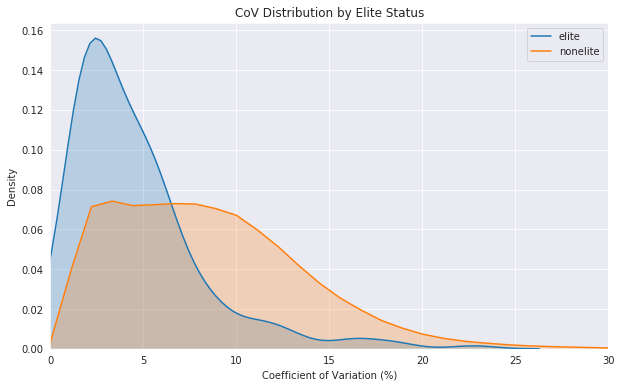

In [35]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['elite'] == 'elite']['cov'], label='elite', shade=True)
sns.kdeplot(df[df['elite'] == 'nonelite']['cov'], label='nonelite', shade=True)

plt.xlabel('Coefficient of Variation (%)')
plt.xlim((0,30))
plt.ylabel('Density')
plt.title('CoV Distribution by Elite Status')  
plt.show()

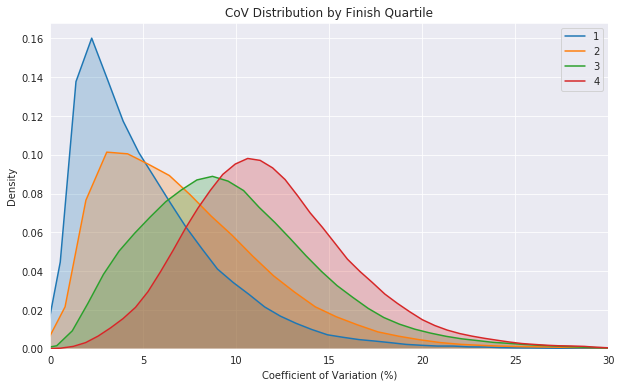

In [36]:
# distribution of CoV based on runner finish quartile
plt.figure(figsize=(10,6))
for q in [1,2,3,4]:
    sns.kdeplot(df[df['quartile'] == q]['cov'], label=q, shade=True)
plt.xlabel('Coefficient of Variation (%)')
plt.xlim((0,30))
plt.ylabel('Density')

plt.title('CoV Distribution by Finish Quartile')   
plt.savefig('img/cov_distr_quartile.png')
plt.show()

In [15]:
# women tend to have a smaller CoV
med = df['cov'].median()
print(med)
df['consistent'] = df['cov'] < med


7.893154815210755


In [16]:
# can see that consistent split runners average faster times - roughly 50 minutes faster!

df.groupby(['elite', 'gender', 'consistent'])['split_Finish'].mean()

# stratify by finish group (probably just do top 25, top 50, top 75, top 100 in M/F separately)


elite     gender  consistent
elite     F       False          9073.200000
                  True           8918.347826
          M       False          8497.130435
                  True           7938.036364
nonelite  F       False         19283.736090
                  True          15975.368829
          M       False         16846.603073
                  True          13664.915640
Name: split_Finish, dtype: float64

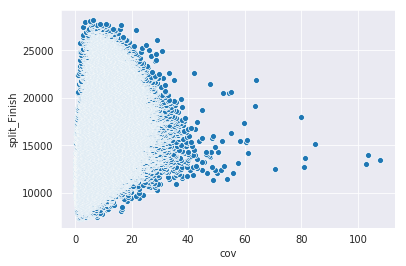

In [17]:
sns.scatterplot(x='cov', y='split_Finish', data=df)

In [18]:
df.groupby(['gender'])['split_Finish', 'cov'].median()

,split_Finish,cov
gender,,
F,17227.0,7.284036
M,15081.0,8.458356


In [19]:
cat = df.groupby(['gender', 'category'])['split_Finish', 'cov'].mean()
#cat['split_Finish'] = split_format(cat, names=['split_Finish'], multi=False)
# convert to minutes
cat['split_Finish'] = cat['split_Finish']/60
cat.reset_index(inplace=True)
cat

,gender,category,split_Finish,cov
0,F,18-39,290.982090,7.910077
1,F,40-44,286.253799,7.205881
2,F,45-49,288.497026,7.290252
3,F,50-54,291.944716,7.591851
4,F,55-59,300.827279,7.866338
5,F,60-64,301.751035,7.712346
6,F,65-69,317.363418,7.961072
7,F,70+,334.630204,8.172214
8,M,18-39,254.903996,9.514103
9,M,40-44,249.617503,8.544753


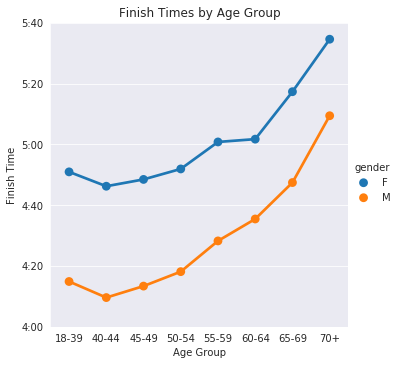

In [20]:
sns.set_style('darkgrid')
ax = sns.catplot(data=cat, x="category", y="split_Finish", hue='gender', 
            linestyles=["-", "-"], kind="point", 
            hue_order = ['F', 'M'])
ax.set(yticks=np.arange(240, 360, 20))
ax.set(yticklabels=['4:00', '4:20', '4:40', '5:00', '5:20', '5:40'])
ax.set(xlabel='Age Group', ylabel='Finish Time', title='Finish Times by Age Group')
ax.fig.savefig('img/finish_by_age.png')

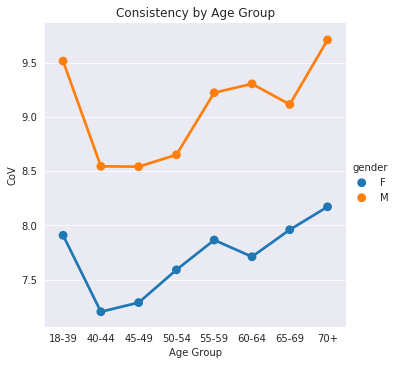

In [21]:
ax = sns.catplot(data=cat, x="category", y="cov", hue='gender', 
            linestyles=["-", "-"], kind="point", 
            hue_order = ['F', 'M'])

ax.set(xlabel='Age Group', ylabel='CoV', title='Consistency by Age Group')
ax.fig.savefig('img/cov_by_age.png')

In [22]:



con = df.groupby(['gender', 'category', 'consistent'])['split_Finish'].mean()/60
con = con.reset_index()
con['Gender/Consistency'] = con['gender'] + con['consistent'].astype('str')
con['Gender/Consistency'] = con['Gender/Consistency'].map({'FFalse': 'F/incon', 
                                                           'FTrue': 'F/con',
                                                          'MFalse': 'M/incon',
                                                          'MTrue': 'M/con'})

# # RECREATE WITH MATPLOTLIB????????
# ax = sns.catplot(data=con, x="category", y="split_Finish", hue="Gender/Consistency", 
#                 linestyles=["-", "--", "-", "--"],
#                 hue_order = ['F/incon', 'F/con', 'M/incon', 'M/con'],
#                 palette = ['C0', 'C0', 'C1', 'C1'],
#                 kind="point")
# ax.set(yticks=np.arange(220, 370, 20))
# ax.set(yticklabels=['3:40', '4:00', '4:20', '4:40', '5:00', '5:20', '5:40', '6:00'])
# ax.set(xlabel='Age Group', ylabel='Finish Time', title='Consistency and Finish Time')
# #ax.fig.savefig('img/finish_by_age_consistent.png')

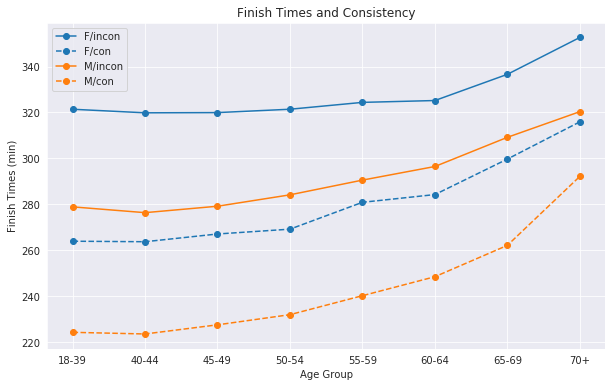

In [23]:
# same plot but with standard matplotlib 
plt.figure(figsize=(10,6))
df1 = con[con['Gender/Consistency'] == 'F/incon']
df2 = con[con['Gender/Consistency'] == 'F/con']
df3 = con[con['Gender/Consistency'] == 'M/incon']
df4 = con[con['Gender/Consistency'] == 'M/con']

plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/incon', data=df1)
plt.plot('category', 'split_Finish', marker='o', color='C0', label='F/con', linestyle='dashed', data=df2)
plt.plot('category', 'split_Finish', marker='o', color='C1', label='M/incon', data=df3)
plt.plot('category', 'split_Finish', marker='o', color='C1', label='M/con', linestyle='dashed',data=df4)
plt.legend()
plt.title('Finish Times and Consistency')
plt.ylabel('Finish Times (min)')
plt.xlabel('Age Group')

plt.savefig('img/finish_by_age_consistent.png')
plt.show()

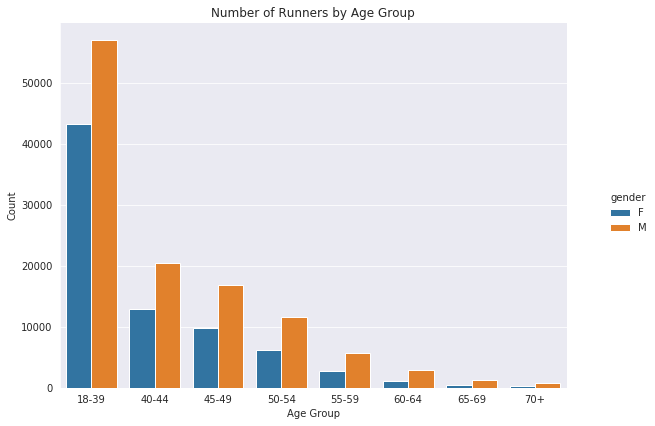

In [24]:
ct = df.groupby(['gender', 'category'])['name'].count()
ct = ct.reset_index()

g = sns.catplot(data=ct, x="category", y="name", hue='gender', 
             kind="bar", 
            hue_order = ['F', 'M'])

g.set(xlabel='Age Group')
g.set(ylabel='Count')
g.set(title='Number of Runners by Age Group')
g.fig.set_size_inches(10,6)
g.fig.savefig('img/count_by_age.png')



# Negative Split Analysis

In [25]:
# common wisdom says negative splits are best
splits = df.loc[:,['name','gender', 'elite', 'category', 'quartile', 'place_category', 'cov', 'split_Half', 'split_Half2', 'split_Finish']]
n = splits.shape[0]


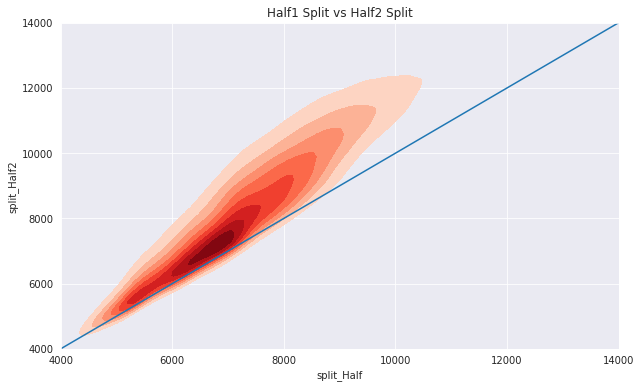

In [49]:
plt.figure(figsize=(10,6))
sns.kdeplot(splits['split_Half'], splits['split_Half2'],cmap="Reds", shade=True, bw=.15, shade_lowest=False,  legend=True)
x = np.linspace(0,14000,14000)
plt.plot(x, x, color='C0')
plt.xlim((4000,14000))
plt.ylim((4000,14000))
plt.title('Half1 Split vs Half2 Split')
plt.savefig('img/negsplit_contour.png')

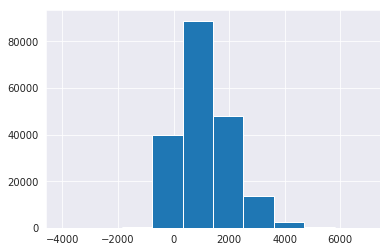

In [27]:
splits['split_delta'] = (splits['split_Half2']-splits['split_Half'])
splits['split_perc'] = splits['split_delta']/splits['split_Finish']
splits['split_delta'].hist()

In [54]:
# what percent of runners ran a true negative split? 
n_neg = splits[splits['split_delta']<=0].shape[0]
n_pos = splits[splits['split_delta']>0].shape[0]
perc_neg = n_neg/n_pos*100
print(perc_neg) 

5.354437966544979


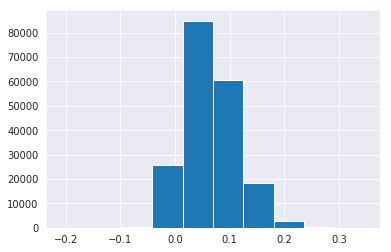

In [28]:
splits['split_perc'].hist()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0.0898855484932017


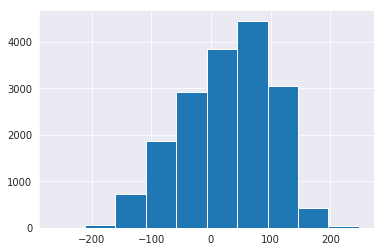

In [29]:
# categorizing runners as neg, even, pos based on split_perc
splits['split_type'] = 'pos'
splits.loc[splits['split_perc'] <= -.01, 'split_type'] = 'neg'

cond = (splits['split_perc'] < .01) & (splits['split_perc'] > -.01)
splits.loc[cond, 'split_type'] = 'even'

even = splits[cond]
even['half/half2p'] = 1 - (even['split_Half']/even['split_Half2'])
even['split_delta'].hist()
print(even.shape[0]/n)

In [30]:
splits.groupby(['gender', 'split_type'])['split_Finish'].mean()

# account for finish time. we split men and women into 4 quartiles (1,2,3,4) for each year.
# we then group by gender, quartile, split_type


gender  split_type
F       even          14860.270266
        neg           15679.712871
        pos           17726.144195
M       even          12708.856696
        neg           13765.168212
        pos           15672.778956
Name: split_Finish, dtype: float64

AttributeError: 'numpy.ndarray' object has no attribute 'fig'

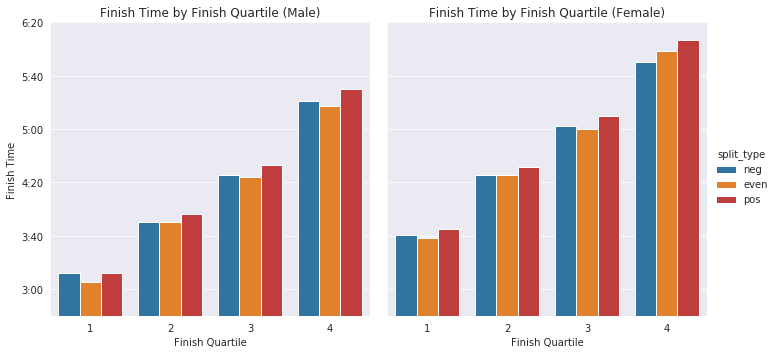

In [40]:
split_type_cat = splits.groupby(['gender', 'quartile', 'split_type'])['split_Finish'].mean()
split_type_cat = split_type_cat.reset_index()
split_type_cat['split_Finish'] = split_type_cat['split_Finish']/60
ax = sns.catplot(data=split_type_cat, x='quartile', y='split_Finish', hue='split_type', 
                 hue_order=['neg', 'even', 'pos'],
                 palette=['C0', 'C1', 'C3'], 
                 col='gender', 
                 col_order=['M','F'], 
                 kind='bar')

ax.set(ylim=(160,360))
ax.set(yticks=np.arange(180, 420, 40))
ax.set(yticklabels=['3:00', '3:40', '4:20', '5:00', '5:40', '6:20'])

ax = ax.axes.flatten()
ax[0].set(title='Finish Time by Finish Quartile (Male)')
ax[1].set(title='Finish Time by Finish Quartile (Female)')
ax[0].set(ylabel='Finish Time')
ax[1].set(xlabel='Finish Quartile')
ax[0].set(xlabel='Finish Quartile')

ax.fig.savefig('img/split_type_quartile.png')

In [ ]:
# pacing strategies of top3 age group placers (M/F)

ag_splits = splits[splits['place_category']<=3].groupby(['gender', 'split_type']).count()
#ag_splits = ag_splits.reset_index()
ag_splits['count'] = ag_splits['name']
ag_splits = ag_splits['count'].reset_index()
ax = sns.catplot(data=ag_splits, x='gender', y='count', hue='split_type', 
                 hue_order=['neg', 'even', 'pos'],
                 palette=['C0', 'C1', 'C3'],
                 kind='bar')
ax.set(xticklabels=['Female','Male'])
ax.set(xlabel='Gender')
ax.set(ylabel='Runner Count')
ax.set(title='Split Type Distribution for Age Group Winners (Top 3)')

ax.fig.savefig('img/split_type_agegroupwinner.png')

In [33]:
# TODO: graph relative pace (current split pace / avg pace) by groups, also might be worth investigating % BQ as well 
# if I have extra time
# ok - this is kind of obv. what isn't obv? consistency by age group?
# finish times by age group?
# finish times by people who have >1 marathon in last 5 yrs?